# Материалы

Прентация: https://disk.yandex.ru/d/CKirw1SwY4LDVg  
Дэшборд: https://public.tableau.com/views/FinalprojectYandex_16967616346330/sheet1?:language=en-GB&:display_count=n&:origin=viz_share_link

# Документация

Система метрик в Ритейле - https://rarus.ru/bonus/finansovye-metriki-v-riteile/   
Оформление презентации - https://artrange.ru/sozdanie-prezentatsiy-10-priemov-po-sozdaniyu-krasivyih-prezentatsiy/    
Справочная информация по графикам - https://matplotlib.org/stable/   

# Предварительная работа

Прописываю свои вспомогательные функции

In [ ]:
# Функция, которая на входе будет получать столбец таблицы, а на выходе давать дипазан нормальных значений (IQR)
def lim_normal_range(series_filtred, rnd = 1):
    # series_filtred - столбец датафрейма.
    # rnd - количество знаков, до которых буду округлять
    # По умолчанию до 1 знака после запятой

    q2=series_filtred.describe()[4]
    q3=series_filtred.describe()[6]
    min_column_name = series_filtred.describe()[3]
    max_column_name = series_filtred.describe()[7]

    x1 = round(max(min_column_name,  q2 - 1.5 * (q3 - q2) ), rnd)
    x2 = round(min(max_column_name,  q3 + 1.5 * (q3 - q2) ), rnd)
    return x1, x2

In [ ]:
#Функция для получения информации о столбце
#На входе имя столбца и дата фрейм
def isnull_columns(column_name, data_framee):
    print('В столбце ',column_name)
    print('Количество ячеек всего:    ',data_framee[column_name].isnull().count())
    print('Количество непустых ячеек: ',data_framee[column_name].count())
    print('Количество пустых ячеек:   ',data_framee[column_name].isnull().sum())
    print('Доля пропусков:            ',data_framee[column_name].isna().mean().astype('int') , '%')
    print('Тип данных в столбце:      ',data_framee[column_name].dtype)
    print('Кол-во уникальных значений:',len(data_framee[column_name].sort_values().unique()))
    print()

In [ ]:
def get_profiles(df):

    profiles = (
        df.query('cat_qua == "Покупки"')
        .sort_values(by=['customer_id','purchase_date'])
        .groupby(['customer_id','loyalty_program'])
        .agg(
            {
                'purchase_date': 'first'
            }
        )
        .rename(columns={'purchase_date': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]').dt.month

    # Меняем типы данных
    profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
    profiles['dt'] = pd.to_datetime(profiles['dt'])

    # проверьте, есть ли ID пользователей из profiles в payments и добавляем payments
    profiles = profiles.merge(payments, on = 'customer_id', how = 'left')
    profiles['payer'] = profiles['customer_id'].isin(payments['customer_id'].unique())
    profiles['payer'] = profiles[['payer']] * 1

    # Меняем типы данных
    profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles['pay_time'] = pd.to_datetime(profiles['purchase_date'])

    return profiles

In [ ]:
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['purchase_date'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 4. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='value',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )
                # Шаг 5. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 6. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer_id': 'nunique'})
            .rename(columns={'customer_id': 'cohort_size'})
        )

        # Шаг 7. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 8. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

In [ ]:
def plot_ltv_roi(ltv, ltv_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[horizon-1]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

# Шаг 1. Откройте файл с данными и изучите общую информацию

Используемые библиотеки

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import date
import plotly.express as px
import seaborn as sns
import numpy as np
from scipy import stats as st

Загружаем данные

In [ ]:
retail = pd.read_csv('https://code.s3.yandex.net/datasets/retail_dataset.csv')

product_codes = pd.read_csv('https://code.s3.yandex.net/datasets/product_codes.csv')

# Шаг 2. Подготовьте данные

#### retail — информация о покупках в магазинах

In [ ]:
# Первые 5 столбцов
display(retail.head())

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [ ]:
# Вызов метода info()
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


In [ ]:
# Изменение формата даты
retail['purchasedate'] = pd.to_datetime(retail['purchasedate'], format='%Y-%m-%d')

# Изменение форматов столбцов
retail['purchaseid'] = retail['purchaseid'].astype("string")
retail['item_ID'] = retail['item_ID'].astype("string")
retail['CustomerID'] = retail['CustomerID'].astype("string")
retail['ShopID'] = retail['ShopID'].astype("string")
retail['Quantity'] = retail['Quantity'].astype('float').astype('int')
retail['loyalty_program'] = retail['loyalty_program'].astype('float').astype('int')

# Изменение названия столбцов

columns_new_name = { #словарь с новыми названиями столбцов
    'purchaseid': 'purchase_id',
    'item_ID': 'item_id',
    'Quantity': 'quantity',
    'purchasedate': 'purchase_date',
    'CustomerID': 'customer_id',
    'ShopID': 'shop_id',
    'loyalty_program': 'loyalty_program'
}

retail = retail.rename(columns = columns_new_name)

display(retail.head())
retail.info()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      105335 non-null  string        
 1   item_id          105335 non-null  string        
 2   quantity         105335 non-null  int64         
 3   purchase_date    105335 non-null  datetime64[ns]
 4   customer_id      69125 non-null   string        
 5   shop_id          105335 non-null  string        
 6   loyalty_program  105335 non-null  int64         
dtypes: datetime64[ns](1), int64(2), string(4)
memory usage: 5.6 MB


Смотрим на дубликаты и пустоты

In [ ]:
print('\n Проверка пропусков:')
display(retail.isna().sum()) # подсчёт пропусков

print('\n Проверка явных дубликатов:', retail.duplicated().sum())


 Проверка пропусков:


purchase_id            0
item_id                0
quantity               0
purchase_date          0
customer_id        36210
shop_id                0
loyalty_program        0
dtype: int64


 Проверка явных дубликатов: 1033


Есть явные дубликаты и очень много пропусков в столбце customer_id.

In [ ]:
isnull_columns('customer_id', retail)

В столбце  customer_id
Количество ячеек всего:     105335
Количество непустых ячеек:  69125
Количество пустых ячеек:    36210
Доля пропусков:             0 %
Тип данных в столбце:       string
Кол-во уникальных значений: 1750



In [ ]:
# Заполним пустоты нулями
retail['customer_id'] = retail['customer_id'].fillna('0')

In [ ]:
display(retail[retail['customer_id'] == '0'].head(10))

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
6,540468,22189,0,2017-01-07 13:55:00,0,Shop 0,0
7,541424,79321,1,2017-01-17 17:57:00,0,Shop 0,0
8,538883,22891,0,2016-12-14 15:56:00,0,Shop 0,0
11,541696,22197,4,2017-01-20 18:08:00,0,Shop 0,0
16,539744,22300,5,2016-12-21 15:21:00,0,Shop 0,0
23,538149,21154,0,2016-12-09 16:27:00,0,Shop 0,0
27,539958,84659A,3,2016-12-23 13:26:00,0,Shop 0,0
28,539451,22376,0,2016-12-17 16:59:00,0,Shop 0,0
30,536920,16235,9,2016-12-03 12:01:00,0,Shop 0,0
32,540468,21990,0,2017-01-07 13:55:00,0,Shop 0,0


Выглядит так, что просто люди пришли купили. То что это единоразовые клиенты или просто препочитают свои данные не оставлять.  
Поправлю значения данного столбца. Не нравится что customer_id 18942.0  
Десятые уберу

In [ ]:
retail['customer_id'] = retail['customer_id'].astype('float').astype('int')
retail['customer_id'] = retail['customer_id'].astype("string")

display(retail.head())

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1


Готово

In [ ]:
# Посмотрим на дубли
duplies_retail = retail[retail.duplicated()]
display(duplies_retail.head()) #537265

# Выведм информацию дубля по одной из покупке
display(duplies_retail[duplies_retail['purchase_id'] == '537265'].head(10))

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
5345,537265,21499,24,2016-12-06 11:26:00,21598,Shop 0,0
5863,540803,21485,0,2017-01-11 12:30:00,20348,Shop 0,0
6893,540524,21326,11,2017-01-09 12:53:00,22414,Shop 0,1
7821,537192,22585,0,2016-12-05 13:42:00,22081,Shop 0,1
10806,537772,22080,4,2016-12-08 12:35:00,23722,Shop 0,1


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
5345,537265,21499,24,2016-12-06 11:26:00,21598,Shop 0,0
19821,537265,21175,0,2016-12-06 11:26:00,21598,Shop 0,0
47625,537265,22960,0,2016-12-06 11:26:00,21598,Shop 0,0
50553,537265,21163,0,2016-12-06 11:26:00,21598,Shop 0,0
74742,537265,79000,11,2016-12-06 11:26:00,21598,Shop 0,0
75242,537265,21163,0,2016-12-06 11:26:00,21598,Shop 0,0
78619,537265,79000,11,2016-12-06 11:26:00,21598,Shop 0,0
86976,537265,22413,0,2016-12-06 11:26:00,21598,Shop 0,0
95372,537265,22844,0,2016-12-06 11:26:00,21598,Shop 0,0
95388,537265,21506,11,2016-12-06 11:26:00,21598,Shop 0,0


Похоже на то что в одном чеке есть разные товары, но почему в одно и тоже время были куплены одни и те же товары, но информацию по ним находится в разных строчках. Дубли такие удалю, это почти тысяча строк из ста тысяч, около 1%

In [ ]:
retail = retail.drop_duplicates().reset_index().drop(['index'], axis = 1)

Посмотрим на неявные дубликаты

In [ ]:
print('Уникальных значений в shop_id', retail.shop_id.nunique())

Уникальных значений в shop_id 31


In [ ]:
set(retail.shop_id.unique())

{'Shop 0',
 'Shop 1',
 'Shop 10',
 'Shop 11',
 'Shop 12',
 'Shop 13',
 'Shop 14',
 'Shop 15',
 'Shop 16',
 'Shop 17',
 'Shop 18',
 'Shop 19',
 'Shop 2',
 'Shop 20',
 'Shop 21',
 'Shop 22',
 'Shop 23',
 'Shop 24',
 'Shop 25',
 'Shop 26',
 'Shop 27',
 'Shop 28',
 'Shop 29',
 'Shop 3',
 'Shop 30',
 'Shop 4',
 'Shop 5',
 'Shop 6',
 'Shop 7',
 'Shop 8',
 'Shop 9'}

Мы имеем 31 уникальный магазин. Немного странно что есть магазин 0. Возможно просто счет так вели

In [ ]:
print('Уникальных значений в purchase_id', retail.purchase_id.nunique())

Уникальных значений в purchase_id 4894


Тут просто информация, что за изучаемый период было совершено 4894 покупок. Не думаю, что здесь есть какие-либо неявности. По item_id и customer_id также выведу информацию

In [ ]:
print('Уникальных значений в item_id', retail.item_id.nunique())
print('Уникальных значений в customer_id', retail.customer_id.nunique())

Уникальных значений в item_id 3159
Уникальных значений в customer_id 1750


Выводы:

- Был загружен блок данных.
- Изменены названия столбцов, они приведены к змеиному регистру.
- Были проанализированы пустоты и дубликаты. Явные дубликаты были удалены, неявные дубликаты обнаружены не были

#### product_codes — информация о ценах продуктов

In [ ]:
# выведем первые 5 строчек
product_codes.head()

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


In [ ]:
# Вызов метода info()
product_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


In [ ]:
# Заменим название productID на item_id и поменяем формат на string
product_codes.columns = ['item_id', 'price_per_one']
product_codes['item_id'] = product_codes['item_id'].astype('string')

display(product_codes.head())
product_codes.info()

,item_id,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   item_id        9969 non-null   string 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), string(1)
memory usage: 155.9 KB


Смотрим на дубликаты и пустоты

In [ ]:
print('\n Проверка пропусков:')
display(product_codes.isna().sum()) # подсчёт пропусков

print('\n Проверка явных дубликатов:', product_codes.duplicated().sum())


 Проверка пропусков:


item_id          0
price_per_one    0
dtype: int64


 Проверка явных дубликатов: 0


Данные в норме.

# Шаг 3. Анализ данных

#### Проанализируем цены продуктов. Есть ли среди них несколько цен на один и тот же продукт

In [ ]:
display(product_codes.describe())

,price_per_one
count,9969.000000
mean,19.503697
std,330.880754
min,0.000000
25%,1.250000
50%,2.550000
75%,5.510000
max,16888.020000


У нас есть бесплатные товары. Посмотрим на них

In [ ]:
zeros = product_codes[product_codes['price_per_one'] == 0]
display(zeros)

,item_id,price_per_one
427,22139,0.0
1356,21134,0.0
1357,22145,0.0
1358,37509,0.0
1363,85226A,0.0
...,...,...
9909,22699,0.0
9910,22698,0.0
9911,22689,0.0
9912,22649,0.0


382 товара из 9969 строчек. Думаю их можно просто удалить. Дальше я планирую брать медианные цены

In [ ]:
product_codes = product_codes[product_codes['price_per_one'] > 0]

In [ ]:
prices = (
    product_codes.pivot_table(index="item_id", values="price_per_one", aggfunc="count")
    .reset_index()
    .sort_values(by="price_per_one", ascending=False)
)

display(prices[prices["price_per_one"] > 1].head())

,item_id,price_per_one
3093,DOT,174
3094,M,59
3096,S,29
3095,POST,14
3086,D,13


Интересно получается, продукт с кодом DOT имеет 174 цены. Посмотрим разброс цен по данному продукту

In [ ]:
dot_min = product_codes[product_codes['item_id'] == 'DOT']['price_per_one'].min()
dot_max = product_codes[product_codes['item_id'] == 'DOT']['price_per_one'].max()

print('Разброс цен у продукта, с наибольшим количество цен состовляет от', dot_min, 'до', dot_max)

Разброс цен у продукта, с наибольшим количество цен состовляет от 2.51 до 950.99


Посмотрим на разброс цен

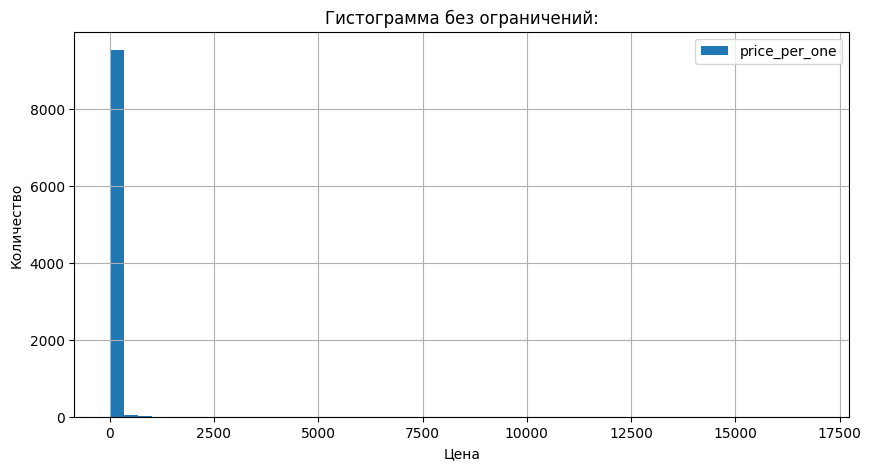

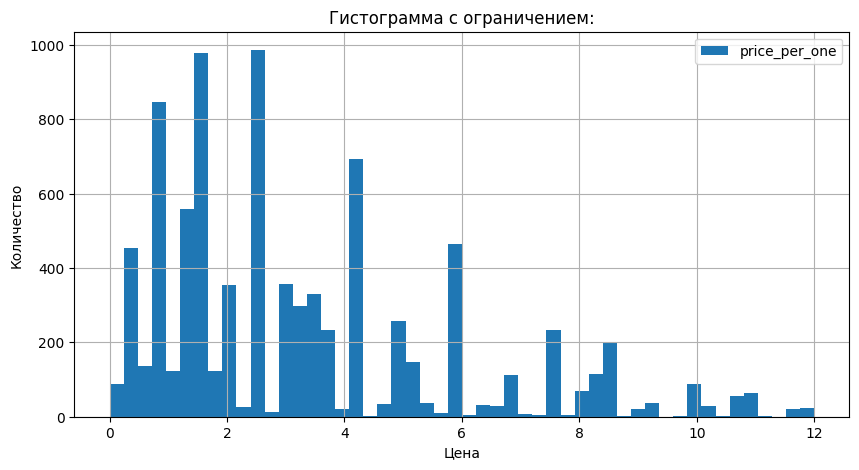

Диапазон нормального распределения: (0.0, 12.0)


In [ ]:
# Изучаемый столбец
column_name = 'price_per_one'

# График без ограничений
product_codes.plot(
    kind='hist',
    y=column_name,
    bins=50,
    figsize=(10,5),
    grid=True
)
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.title('Гистограмма без ограничений:')
plt.show();

# График нормального распределения
product_codes.plot(
    kind='hist',
    y=column_name,
    bins=50,
    figsize=(10,5),
    grid=True,
    range = lim_normal_range(product_codes[column_name]) #ограничение через функцию
)
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.title('Гистограмма с ограничением:')
plt.show();

print('Диапазон нормального распределения:', lim_normal_range(product_codes[column_name]))

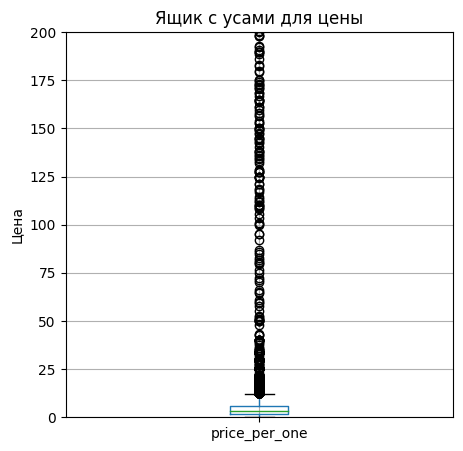

Числовое описание данных:


count     9587.0
mean        20.3
std        337.4
min          0.0
25%          1.6
50%          3.0
75%          5.8
max      16888.0
Name: price_per_one, dtype: float64

In [ ]:
# Диаграмма размаха (Ящик с усами):
product_codes.boxplot(column=column_name, figsize=(5,5))
plt.ylim(0, 200) #ставлю лимит, чтобы график был читаемый
plt.ylabel('Цена')
showfliers=False
plt.title('Ящик с усами для цены')
plt.show()
print('Числовое описание данных:')
round(product_codes[column_name].describe(),1)

Видно, что цены бывают совершенно разные. Чаще всего это различные мелочи с небольшой ценой. Думаю такой же анализ можно сделать поитогу перемножения проданных штук и цены на них. Пока надо решить проблему с несколькими ценами для одного товара. Возьму медиану по данным ценам

In [ ]:
median_prices = product_codes.groupby('item_id').agg({'price_per_one':'median'}).reset_index()

display(product_codes.describe())
print('Медианная цена', product_codes['price_per_one'].median())
display(median_prices.describe())
print('Медианная цена', median_prices['price_per_one'].median())

,price_per_one
count,9587.000000
mean,20.280834
std,337.385754
min,0.030000
25%,1.630000
50%,2.950000
75%,5.790000
max,16888.020000


Медианная цена 2.95


,price_per_one
count,3102.000000
mean,6.976389
std,120.753629
min,0.100000
25%,1.630000
50%,2.950000
75%,5.510000
max,6706.710000


Медианная цена 2.95


Количеств цен стало меньше почти в 3 раза. Условно у каждого продукта было три цены. Квартили 1 и 2 никак не поменялись, а 3 квартиль поменялся незначительно. Медианная цена не изменилась

Вывод:

В предоставленном блоке данных цены на товары не уникальные. Мы не можем точно знать, когда они поменялись. Поэтому был составлен блок данных с медианным ценами по каждому товару, в дальнейшем он будет использоваться.  
Медианная цена товаров 2.95

### Сводим retail и цены

In [ ]:
# Получаем общий df
df = pd.merge(retail, median_prices, on = 'item_id', how = 'left')

display(df.head())
df.info()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.630
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,3.290
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,1.630
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,4.370
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,7.855


<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 104301
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      104302 non-null  string        
 1   item_id          104302 non-null  string        
 2   quantity         104302 non-null  int64         
 3   purchase_date    104302 non-null  datetime64[ns]
 4   customer_id      104302 non-null  string        
 5   shop_id          104302 non-null  string        
 6   loyalty_program  104302 non-null  int64         
 7   price_per_one    104243 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(4)
memory usage: 7.2 MB


Пропуски с ценами есть. Глянем на эти данные. Может там нулевые продажи

In [ ]:
df['price_per_one'] = df['price_per_one'].fillna(0)

display(df[df['price_per_one'] == 0].head(10))

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one
3806,538142,84247C,0,2016-12-09 15:58:00,0,Shop 0,0,0.0
6263,543258,84611B,1286,2017-02-04 16:06:00,0,Shop 0,0,0.0
8574,542570,85028S,-2,2017-01-28 14:53:00,0,Shop 0,0,0.0
9642,542581,90091,-2,2017-01-28 14:58:00,0,Shop 0,0,0.0
9692,540987,17011A,-62,2017-01-12 16:15:00,0,Shop 0,0,0.0
10683,543257,84611B,-1431,2017-02-04 16:06:00,0,Shop 0,0,0.0
12691,542576,85179B,-2,2017-01-28 14:56:00,0,Shop 0,0,0.0
15838,542414,84967A,-3,2017-01-27 17:15:00,0,Shop 0,0,0.0
16349,536549,85226A,0,2016-12-01 14:34:00,0,Shop 0,0,0.0
16385,542418,84966A,-18,2017-01-27 17:39:00,0,Shop 0,0,0.0


Мало нулевых значений. Много возвратов и есть большие покупки. Попробую поискать цены в исходном df. Может быть там есть цены. Интересное замечание, что все эти нулевые цены только в магазине 0

In [ ]:
df_test = pd.merge(retail, product_codes, on = 'item_id', how = 'left')

df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488517 entries, 0 to 488516
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      488517 non-null  string        
 1   item_id          488517 non-null  string        
 2   quantity         488517 non-null  int64         
 3   purchase_date    488517 non-null  datetime64[ns]
 4   customer_id      488517 non-null  string        
 5   shop_id          488517 non-null  string        
 6   loyalty_program  488517 non-null  int64         
 7   price_per_one    488458 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(4)
memory usage: 33.5 MB


Даже если брать весь блок с большим количеством цен, все равно есть пропуски. Посмотрим может у всего нулегого магазина нет цен или какие-либо другие вещи сможем найти

In [ ]:
display(df[df['shop_id'] == "Shop 0"].describe())

,quantity,loyalty_program,price_per_one
count,96370.000000,96370.000000,96370.000000
mean,6.871724,0.241476,5.518222
std,342.551384,0.427980,72.327678
min,-74216.000000,0.000000,0.000000
25%,0.000000,0.000000,1.660000
50%,1.000000,0.000000,3.115000
75%,6.000000,0.000000,5.605000
max,74214.000000,1.000000,6706.710000


Нет. У данного магазина много покупок и по большей части есть цены. Тогда просто учтем это, что у части продуктов в магазине 0 нет цен.

Вывод:

У части продуктов нет цены, но их количество крайне малое. Удалось объеденить блоки данных и посчитать деньги

### Добавим новые столбцы

In [ ]:
# Добавим столбцы с годом, месяцем, днем недели, днем, часом и перемножим количество покупок и цены на эти покупки

df['value'] = (df['quantity'] * df['price_per_one']).round(2)
df['year'] = df['purchase_date'].dt.year
df['month'] = df['purchase_date'].dt.month
df['weekday'] = df['purchase_date'].dt.weekday + 1
df['day'] = df['purchase_date'].dt.day
df['hour'] = df['purchase_date'].dt.hour
df['hour_start'] = df['purchase_date'].round('H')

df.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,value,year,month,weekday,day,hour,hour_start
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.630,17.93,2016,12,6,10,12,2016-12-10 13:00:00
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,3.290,0.00,2016,12,3,14,14,2016-12-14 14:00:00
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,1.630,11.41,2016,12,3,14,13,2016-12-14 14:00:00
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,4.370,0.00,2017,2,4,9,15,2017-02-09 16:00:00
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,7.855,0.00,2017,2,1,13,14,2017-02-13 15:00:00


Готово

### Взглянем на покупки

Посмотрим за какой период у нас есть данные

In [ ]:
print('Мы имеем данные с', df['purchase_date'].min(), 'до', df['purchase_date'].max())

Мы имеем данные с 2016-12-01 08:26:00 до 2017-02-28 17:04:00


С декабря 2016 года до февраля 2017 года. Три месяца

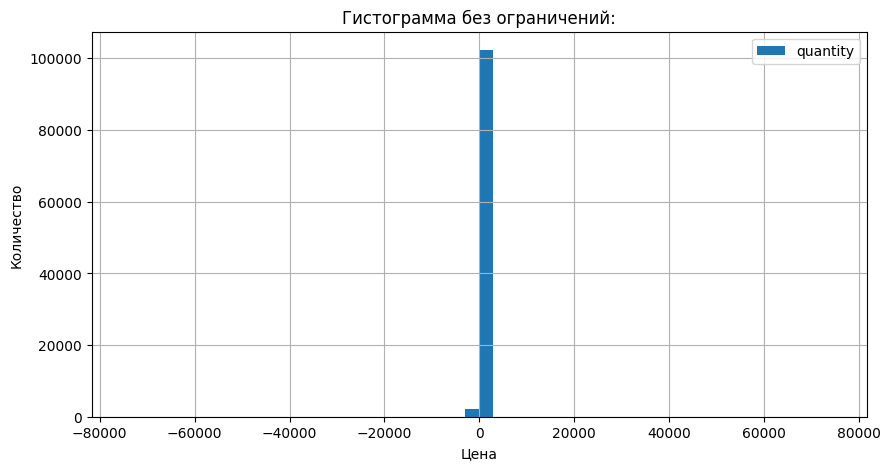

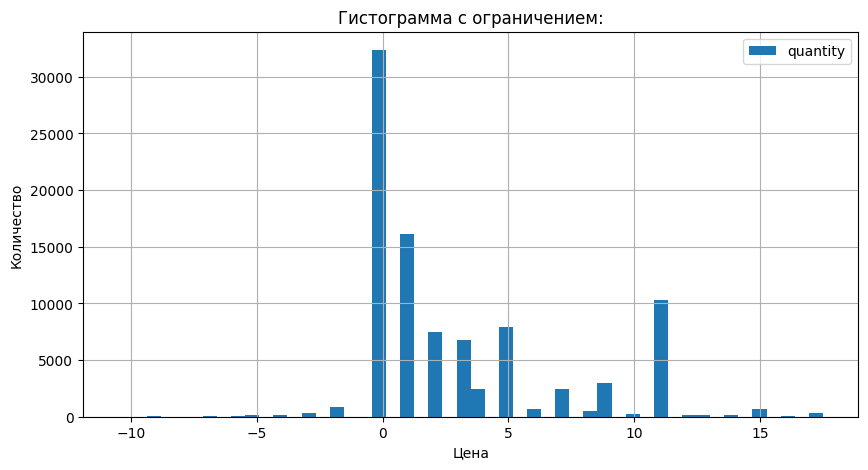

Диапазон нормального распределения: (-10.5, 17.5)


In [ ]:
# Изучаемый столбец
column_name = 'quantity'

# График без ограничений
df.plot(
    kind='hist',
    y=column_name,
    bins=50,
    figsize=(10,5),
    grid=True
)
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.title('Гистограмма без ограничений:')
plt.show();

# График нормального распределения
df.plot(
    kind='hist',
    y=column_name,
    bins=50,
    figsize=(10,5),
    grid=True,
    range = lim_normal_range(df[column_name]) #ограничение через функцию
)
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.title('Гистограмма с ограничением:')
plt.show();

print('Диапазон нормального распределения:', lim_normal_range(df[column_name]))

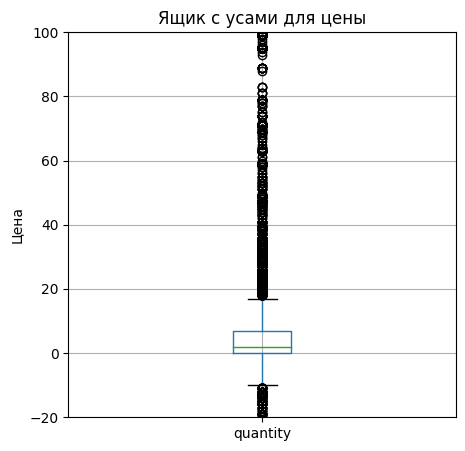

Числовое описание данных:


count    104302.0
mean          7.9
std         329.6
min      -74216.0
25%           0.0
50%           2.0
75%           7.0
max       74214.0
Name: quantity, dtype: float64

In [ ]:
# Диаграмма размаха (Ящик с усами):
df.boxplot(column=column_name, figsize=(5,5))
plt.ylim(-20, 100) #ставлю лимит, чтобы график был читаемый
plt.ylabel('Цена')
showfliers=False
plt.title('Ящик с усами для цены')
plt.show()
print('Числовое описание данных:')
round(df[column_name].describe(),1)

In [ ]:
# Обрежем df аномальными значениями. Также посмотрим, что это такие за огромные заказы и возвраты

big_paybacks = df[df['quantity'] < -10.5]
big_orders = df[df['quantity'] > 18]
df = df[df['quantity'] >= -10.5]
df = df[df['quantity'] <= 17.5]

#### Большие возвраты big_paybacks

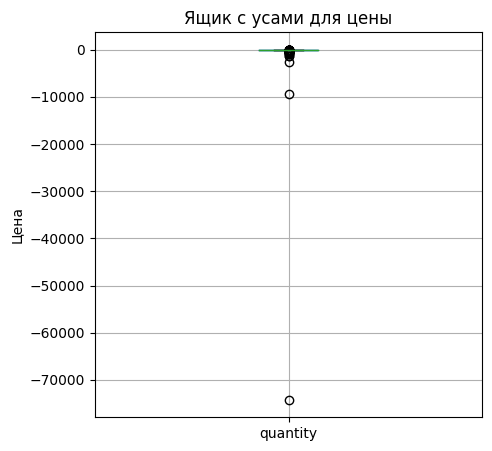

Числовое описание данных:


count      490.0
mean      -233.4
std       3379.7
min     -74216.0
25%        -49.0
50%        -25.0
75%        -13.0
max        -11.0
Name: quantity, dtype: float64

In [ ]:
# Диаграмма размаха (Ящик с усами):
big_paybacks.boxplot(column=column_name, figsize=(5,5))
plt.ylabel('Цена')
showfliers=False
plt.title('Ящик с усами для цены')
plt.show()
print('Числовое описание данных:')
round(big_paybacks[column_name].describe(),1)

In [ ]:
# Два супер больших возврата, которые портят всю картину. Посмотрим на них отдельно и исключим

display(big_paybacks[big_paybacks['quantity'] < -5000])

big_paybacks = big_paybacks[big_paybacks['quantity'] != -74216]
big_paybacks = big_paybacks[big_paybacks['quantity'] != -9361]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,value,year,month,weekday,day,hour,hour_start
39189,C536757,84347,-9361,2016-12-02 14:23:00,21517,Shop 0,0,3.755,-35150.56,2016,12,5,2,14,2016-12-02 14:00:00
49166,C541433,23166,-74216,2017-01-18 10:17:00,18025,Shop 0,0,1.040,-77184.64,2017,1,3,18,10,2017-01-18 10:00:00


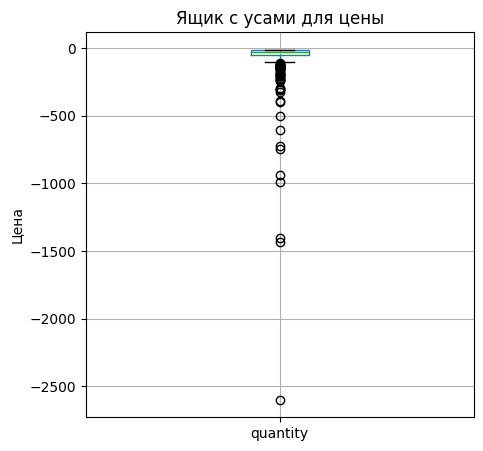

Числовое описание данных:


count     488.0
mean      -63.1
std       174.0
min     -2601.0
25%       -49.0
50%       -25.0
75%       -13.0
max       -11.0
Name: quantity, dtype: float64

In [ ]:
# Диаграмма размаха (Ящик с усами):
big_paybacks.boxplot(column=column_name, figsize=(5,5))
plt.ylabel('Цена')
showfliers=False
plt.title('Ящик с усами для цены')
plt.show()
print('Числовое описание данных:')
round(big_paybacks[column_name].describe(),1)

In [ ]:
grouped_big_paybacs = (big_paybacks.groupby(
        ["shop_id", "customer_id", "item_id"]
    )
    .agg(
        {
            "quantity": "sum",  # количество проданных вещей
            "price_per_one": "median",  # медианная цена
            "value": "sum", # сумма продаж
        }
    )
    .reset_index())

display(grouped_big_paybacs.head())

,shop_id,customer_id,item_id,quantity,price_per_one,value
0,Shop 0,0,17011A,-62,0.00,0.00
1,Shop 0,0,17165D,-11,1.05,-11.55
2,Shop 0,0,18098C,-141,2.95,-415.95
3,Shop 0,0,20684,-20,5.01,-100.20
4,Shop 0,0,20699,-17,2.53,-43.01


In [ ]:
fig_1 = px.bar(
    grouped_big_paybacs.sort_values(by="value", ascending=False).head(100),
    y="value",
    x="shop_id",
    title="График крупных возвратов в разбивке по магазинам",
    color="customer_id",
    hover_data=[
        "quantity",
        "price_per_one"
    ],
)
fig_1.show()

Есть магазины, в которые всегда приходят одни и те же пользователи, что совершают крупную покупку и крупный возврат

In [ ]:
clients_info_minus = grouped_big_paybacs.groupby(['customer_id','shop_id']).agg({'quantity':'sum'}).reset_index()

display(clients_info_minus.sort_values(by = 'quantity', ascending = True).head(10))

,customer_id,shop_id,quantity
0,0,Shop 0,-18784
110,22225,Shop 0,-858
99,21692,Shop 0,-802
132,23047,Shop 0,-728
48,19835,Shop 6,-678
37,19359,Shop 0,-665
14,18587,Shop 0,-601
47,19825,Shop 0,-538
68,20590,Shop 6,-428
87,21193,Shop 0,-301


#### Большие покупки big_orders

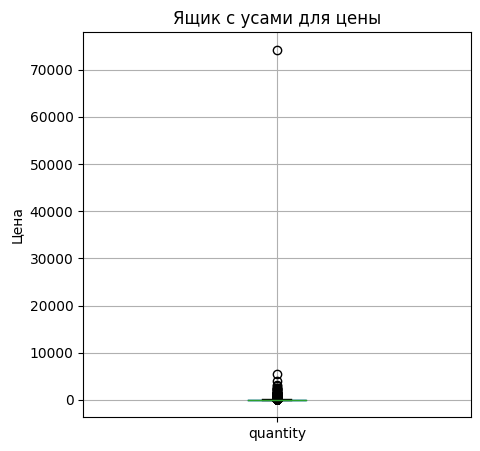

Числовое описание данных:


count    10535.0
mean        61.8
std        734.3
min         19.0
25%         23.0
50%         24.0
75%         47.0
max      74214.0
Name: quantity, dtype: float64

In [ ]:
# Диаграмма размаха (Ящик с усами):
big_orders.boxplot(column=column_name, figsize=(5,5))
plt.ylabel('Цена')
showfliers=False
plt.title('Ящик с усами для цены')
plt.show()
print('Числовое описание данных:')
round(big_orders[column_name].describe(),1)

In [ ]:
# По аналогии уберем супер большую покупку

display(big_orders[big_orders['quantity'] > 10000])

big_orders = big_orders[big_orders['quantity'] != 74214]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,value,year,month,weekday,day,hour,hour_start
68612,541431,23166,74214,2017-01-18 10:01:00,18025,Shop 0,0,1.04,77182.56,2017,1,3,18,10,2017-01-18 10:00:00


In [ ]:
grouped_big_orders = (big_orders.groupby(
        ["shop_id", "customer_id", "item_id"]
    )
    .agg(
        {
            "quantity": "sum",  # количество проданных вещей
            "price_per_one": "median",  # медианная цена
            "value": "sum", # сумма продаж
        }
    )
    .reset_index())

display(grouped_big_orders.head())

,shop_id,customer_id,item_id,quantity,price_per_one,value
0,Shop 0,0,10133,21,0.830,17.43
1,Shop 0,0,10135,47,1.265,59.46
2,Shop 0,0,15036,54,1.000,54.00
3,Shop 0,0,15039,29,1.630,47.27
4,Shop 0,0,16033,119,0.120,14.28


In [ ]:
fig_2 = px.bar(
    grouped_big_orders.sort_values(by="value", ascending=False).head(100),
    y="value",
    x="shop_id",
    title="График крупных возвратов в разбивке по магазинам",
    color="customer_id",
    hover_data=[
        "quantity",
        "price_per_one"
    ],
)
fig_2.show()

In [ ]:
clients_info_plus = grouped_big_orders.groupby(['customer_id','shop_id']).agg({'quantity':'sum'}).reset_index()

display(clients_info_plus.sort_values(by = 'quantity', ascending = False).head(10))

,customer_id,shop_id,quantity
513,20325,Shop 3,42288
0,0,Shop 0,33799
1070,23190,Shop 0,13540
21,18094,Shop 2,12948
777,21708,Shop 0,12239
309,19373,Shop 0,11737
445,19977,Shop 0,10680
588,20740,Shop 0,10592
415,19835,Shop 6,10541
1199,23781,Shop 0,9090


Интересно получается. В возвратов больше всего в shop 0, а в покупках shop 3. Там и там я убрал супер большие значения, они все были в shop 0

Вывод:

Мы имеем данные за три месяца. С декабря 2016 по февраль 2017 годов. Были отброшены аномальные значения. Аномалии были проанализованы и они чаще всего приходятся на людей, которые очень много покупают. Они также приходят в один или два магазина. С точки зрения финансов это здорово, что такие клиенты есть и что они приносят много денег. Но для анализа данных это аномалии

### Общая информация о покупках

На предобработке были обнаружены отрицательные значения в столбце количество. Думаю, что это возвраты. Но также есть нули взглянем сколько отрицательных, нулевых и положительных значений мы имеем

In [ ]:
quantity_info = df.copy()


def min_plus(qua):  # Функция для определения знака у значения quantity
    if qua != 0:
        if qua > 0:
            return "Покупки"
        else:
            return "Нулевые значения"
    else:
        return "Возвраты"


quantity_info["cat_qua"] = quantity_info.apply(lambda x: min_plus(x.quantity), axis=1)

quant_infos = (
    quantity_info.groupby("cat_qua")["quantity"]
    .count()
    .reset_index()
    .rename(columns={"cat_qua": "category", "quantity": "count_of_items"})
    .sort_values(by="count_of_items", ascending=False)
)

quant_infos["percent"] = (quant_infos["count_of_items"] / quant_infos["count_of_items"].sum() * 100).round(2)  # Проценты

# Выведу таблицу
display(quant_infos)

# Построю визуализацию
pie_1 = px.pie(
    quant_infos,
    values="count_of_items",
    names="category",
    title="Круговая диаграмма по категориям покупок",
    hole=0.3,
)
pie_1.show()

df = quantity_info

,category,count_of_items,percent
2,Покупки,59274,63.58
0,Возвраты,32362,34.71
1,Нулевые значения,1586,1.70


Получается так что у почти каждая третий товар это возврат. Также почти 2% это нулевые значения. Проанализируем данные по отдельности

Проанализируем, на какие магазины приходятся нули и больше всего возвратов

In [ ]:
mags_extras = (
    df.pivot_table(
        index="shop_id", columns="cat_qua", values="quantity", aggfunc="count"
    )
    .reset_index()
    .fillna(0)
    .sort_values(by="Возвраты", ascending=False)
)

mags_extras['Доля_возвратов'] = (mags_extras['Возвраты'] / (mags_extras['Возвраты'] + mags_extras['Нулевые значения'] + mags_extras['Покупки']) * 100).round(2)
mags_extras['Доля_нулей'] = (mags_extras['Нулевые значения'] / (mags_extras['Возвраты'] + mags_extras['Нулевые значения'] + mags_extras['Покупки']) * 100).round(2)
mags_extras['Доля_покупок'] = (mags_extras['Покупки'] / (mags_extras['Возвраты'] + mags_extras['Нулевые значения'] + mags_extras['Покупки']) * 100).round(2)

display(mags_extras.sort_values(by = 'Покупки', ascending = False))

cat_qua,shop_id,Возвраты,Нулевые значения,Покупки,Доля_возвратов,Доля_нулей,Доля_покупок
0,Shop 0,32042.0,1348.0,54031.0,36.65,1.54,61.81
24,Shop 4,47.0,146.0,1215.0,3.34,10.37,86.29
1,Shop 1,78.0,24.0,1143.0,6.27,1.93,91.81
26,Shop 6,33.0,27.0,744.0,4.10,3.36,92.54
28,Shop 8,50.0,7.0,453.0,9.80,1.37,88.82
2,Shop 10,7.0,4.0,232.0,2.88,1.65,95.47
27,Shop 7,1.0,2.0,212.0,0.47,0.93,98.60
4,Shop 12,8.0,8.0,208.0,3.57,3.57,92.86
10,Shop 18,40.0,1.0,170.0,18.96,0.47,80.57
3,Shop 11,2.0,8.0,143.0,1.31,5.23,93.46


Получается так что у нас есть один супер большой магазин shop 0 и все остальные. У кого-то количество продаж тысячи, а у кого-то их десятки.
Среди магазинов, есть некоторые, у которых вообще не наблюдается нулей или возвратов. А есть Shop 14 с большой долей возвратов почти 66%

Посмотрим на численные показатели магазинов

In [ ]:
# Нам важно посмотреть именно на покупки.
# Вернуть товар может любой пользователей.
# А нулевые покупки непонятные вещи, поэтому дальше мы бдуем смотреть только на положительные

mags_money = (
    df.query('cat_qua == "Покупки"').groupby("shop_id").agg({"quantity": "sum", "value": "sum"}).reset_index()
)

mags_money["perc_quan"] = (mags_money["quantity"] / mags_money["quantity"].sum() * 100).round(2)
mags_money["perc_val"] = (mags_money["value"] / mags_money["value"].sum() * 100).round(2)

display(mags_money.sort_values(by="value", ascending=False))

,shop_id,quantity,value,perc_quan,perc_val
0,Shop 0,252585,892622.97,87.21,85.75
24,Shop 4,9022,34693.37,3.12,3.33
1,Shop 1,8582,31170.89,2.96,2.99
26,Shop 6,4664,20499.57,1.61,1.97
28,Shop 8,2554,9536.80,0.88,0.92
2,Shop 10,1662,6927.90,0.57,0.67
27,Shop 7,1516,5456.17,0.52,0.52
4,Shop 12,1424,5155.19,0.49,0.50
12,Shop 2,769,3864.55,0.27,0.37
10,Shop 18,979,3792.67,0.34,0.36


История с доминированием одним магазином подтвердилась. Больше всего товара продает один магазин. Все остальные магазины это максимум почти 4% от общей выручки

Посмотрим на дату первой покупки в каждом магазине

In [ ]:
first_buy = df.query('cat_qua == "Покупки"').groupby('shop_id').agg({'purchase_date':'first', 'quantity':'sum'}).reset_index()
first_buy.columns = ['shop_id','first_purchase_date','sum_quantities']

display(first_buy.sort_values(by = 'first_purchase_date', ascending = True))

first_buy['month'] = first_buy['first_purchase_date'].dt.month

month_buy = first_buy.groupby('month')['shop_id'].count().reset_index()
display(month_buy)

,shop_id,first_purchase_date,sum_quantities
3,Shop 11,2016-12-03 15:45:00,1006
5,Shop 13,2016-12-05 12:00:00,267
6,Shop 14,2016-12-05 15:46:00,160
7,Shop 15,2016-12-07 14:57:00,349
25,Shop 5,2016-12-08 16:49:00,737
0,Shop 0,2016-12-10 12:50:00,252585
13,Shop 20,2016-12-17 09:38:00,135
11,Shop 19,2016-12-17 10:54:00,157
28,Shop 8,2017-01-07 14:04:00,2554
29,Shop 9,2017-01-17 10:37:00,387


,month,shop_id
0,1,11
1,2,11
2,12,8


У нас есть информация по 30 магазинам. В 8 из них покупки были в декабре. в 11 магазинах в январе и в фервале. Все магазины относительно новые. Причем если смотреть на самые новые магазины 30 и 1, то видно, что в 30 магазине было куплено 57 вещей, а в 1 магазине 8582.

Разобьем продажи по магазинам на те что были совершены клиентами с програмой лояльности и без

In [ ]:
shops_programs = (df.query('cat_qua == "Покупки"')
                    .pivot_table(index = 'shop_id', columns = 'loyalty_program', values = 'value', aggfunc = 'sum')
                    .reset_index().fillna(0))
shops_programs.columns = ['shop_id','no_loyal','loyal']
shops_programs['perc_of_loyal'] = (shops_programs['loyal'] / (shops_programs['loyal'] + shops_programs['no_loyal']) * 100).round(2)

display(shops_programs)

,shop_id,no_loyal,loyal,perc_of_loyal
0,Shop 0,630709.66,261913.31,29.34
1,Shop 1,31170.89,0.00,0.00
2,Shop 10,6927.90,0.00,0.00
3,Shop 11,3585.92,0.00,0.00
4,Shop 12,5155.19,0.00,0.00
5,Shop 13,1317.61,0.00,0.00
6,Shop 14,490.26,0.00,0.00
7,Shop 15,1239.76,0.00,0.00
8,Shop 16,847.97,0.00,0.00
9,Shop 17,1247.71,0.00,0.00


Только в 4 магазинах были совершены покупки клиентов, у которых есть программа лояльности. В магазине 28 покупки совершаются людьми только с программой лояльности

Сгруппируем данные по покупкам. Нам важно посмотреть на то как люди покупают с программой лояльности и без нее

In [ ]:
grouped_loyal = (df.query('cat_qua == "Покупки"')
                   .groupby(['purchase_id','customer_id','shop_id','purchase_date','loyalty_program'])
                   .agg({'item_id':'count','quantity':'sum','value':'sum'})
                   .reset_index())

display(grouped_loyal.head())

,purchase_id,customer_id,shop_id,purchase_date,loyalty_program,item_id,quantity,value
0,536365,23529,Shop 0,2016-12-01 08:26:00,1,7,33,197.39
1,536366,23529,Shop 0,2016-12-01 08:28:00,1,2,10,21.00
2,536367,18726,Shop 0,2016-12-01 08:34:00,0,11,40,222.77
3,536368,18726,Shop 0,2016-12-01 08:34:00,0,4,11,96.09
4,536369,18726,Shop 0,2016-12-01 08:35:00,0,1,2,13.20


In [ ]:
# столбец с датой
grouped_loyal['date'] = grouped_loyal['purchase_date'].dt.date

# График в деньгах
fig_1 = grouped_loyal.pivot_table(
    index="date", columns="loyalty_program", values="value", aggfunc="sum"
).reset_index().fillna(0)

fig_1 = px.line(fig_1, x='date', y=fig_1.columns, markers=True)
fig_1.update_layout(title='Помесячные продажи в деньгах',
                   xaxis_title='Даты',
                   yaxis_title='Сумма проданных товаров')
fig_1.show();

# График в штуках
fig_2 = grouped_loyal.pivot_table(
    index="date", columns="loyalty_program", values="quantity", aggfunc="sum"
).reset_index().fillna(0)

fig_2 = px.line(fig_2, x='date', y=fig_2.columns, markers=True)
fig_2.update_layout(title='Помесячные продажи в штуках',
                   xaxis_title='Даты',
                   yaxis_title='Количество проданных товаров')
fig_2.show()

Если говорить про сумму в деньгах и штуках, то всего три дня за три месяца, когда люди с программой лояльности покупали больше

In [ ]:
# График в деньгах
fig_3 = grouped_loyal.pivot_table(
    index="date", columns="loyalty_program", values="value", aggfunc="median"
).reset_index().fillna(0)

fig_3 = px.line(fig_3, x='date', y=fig_3.columns, markers=True)
fig_3.update_layout(title='Помесячные продажи в деньгах',
                   xaxis_title='Даты',
                   yaxis_title='Медианная покупка в деньгах')
fig_3.show();

# График в штуках
fig_4 = grouped_loyal.pivot_table(
    index="date", columns="loyalty_program", values="quantity", aggfunc="median"
).reset_index().fillna(0)

fig_4 = px.line(fig_4, x='date', y=fig_4.columns, markers=True)
fig_4.update_layout(title='Помесячные продажи в штуках',
                   xaxis_title='Даты',
                   yaxis_title='Медианная покупка в штуказ')
fig_4.show()

На медианных тратах, уже ситуация лучше. Но нет прям какого-то решающего преимущества иметь эту программу лояльности. Просто как приятный бонус или момент поддержки компании

Тепловая карта для тех у кого есть программа лояльности


<Axes: xlabel='hour', ylabel='weekday'>

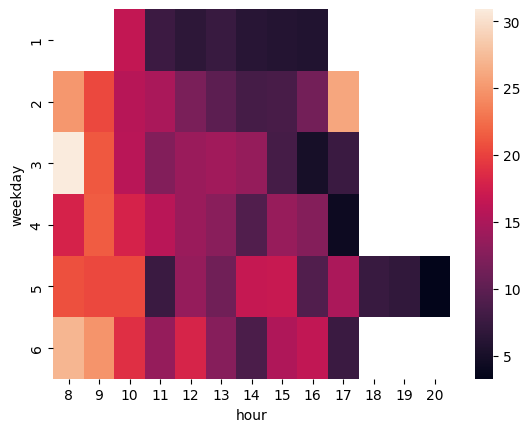

In [ ]:
print("Тепловая карта для тех у кого есть программа лояльности")
sns.heatmap(
    df.query('cat_qua == "Покупки"')
    .query("loyalty_program == 1")
    .pivot_table(index="weekday", columns="hour", values="value", aggfunc="median")
)

Тепловая карта для тех у кого нет программы лояльности


<Axes: xlabel='hour', ylabel='weekday'>

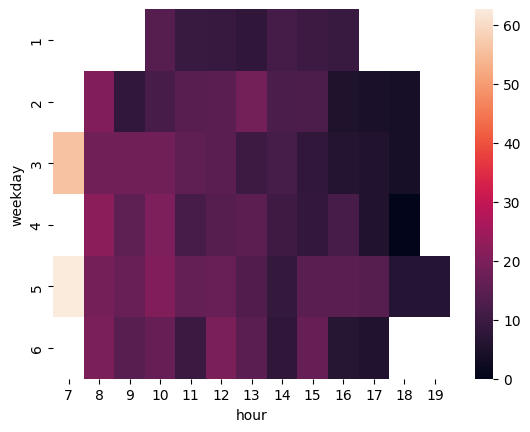

In [ ]:
print("Тепловая карта для тех у кого нет программы лояльности")
sns.heatmap(
    df.query('cat_qua == "Покупки"')
    .query("loyalty_program == 0")
    .pivot_table(index="weekday", columns="hour", values="value", aggfunc="median")
)

Если смотреть продажи по часа в неделе, то получается так, что клиенты без программы лояльности предпочитают совершать покупки с утра с 7 до 8. А те кто с программой лояльности не покупали никогда в с 7 утра, но тоже предпочитают покупать утром. Самый пик приходится только во вторник в 17. Также в пятницу пользователи с программой лояльности покупают в 20, а у тех у кого нет программы лояльности вообще в такое время не покупают

Графики MAU/WAU/DAU для всей сети.

In [ ]:
# MAU

def year_month(year, month): # Функция для расчет даты с первым числом месяца
    return date(year, month, 1)

df['year_month'] = df.apply(lambda x: year_month(x.year, x.month), axis=1)

mau = df.pivot_table(index = 'year_month', columns = 'loyalty_program', values = 'customer_id', aggfunc = 'nunique').reset_index()

# Визуализация

fig_5 = px.line(mau, x='year_month', y=mau.columns, markers=True)
fig_5.update_layout(title='График метрики MAU',
                   xaxis_title='Даты',
                   yaxis_title='Уникальное количество пользователей')
fig_5.show()

In [ ]:
# DAU

def year_month_day(year, month, day): # Функция для расчет даты с первым числом месяца
    return date(year, month, day)

df['year_month_day'] = df.apply(lambda x: year_month_day(x.year, x.month, x.day), axis=1)
dau = df.pivot_table(index = 'year_month_day', columns = 'loyalty_program', values = 'customer_id', aggfunc = 'nunique').reset_index()

# Визуализация

fig_6 = px.line(dau, x='year_month_day', y=dau.columns, markers=True)
fig_6.update_layout(title='График метрики DAU',
                   xaxis_title='Даты',
                   yaxis_title='Уникальное количество пользователей')
fig_6.show()

In [ ]:
# WAU

def week_number(year_month_day): # Функция для расчет даты с первым числом месяца
    return year_month_day.isocalendar()[1]

df['week_number'] = df.apply(lambda x: week_number(x.year_month_day), axis=1)

wau = df.pivot_table(index = ['year','week_number'], columns = 'loyalty_program', values = 'customer_id', aggfunc = 'nunique').reset_index()

# Разделим данные на два года
wau_2016 = wau.query('year == 2016')
wau_2016 = wau_2016.drop(['year'], axis = 1)

wau_2017 = wau.query('year == 2017')
wau_2017 = wau_2017.drop(['year'], axis = 1)

# Визуализация
fig_7_1 = px.line(wau_2016, x='week_number', y=wau_2016.columns, markers=True)
fig_7_1.update_layout(title='График метрики WAU за 2016 год',
                   xaxis_title='Номер недели',
                   yaxis_title='Уникальное количество пользователей')
fig_7_1.show()

fig_7_2 = px.line(wau_2017, x='week_number', y=wau_2017.columns, markers=True)
fig_7_2.update_layout(title='График метрики WAU за 2017 год',
                   xaxis_title='Номер недели',
                   yaxis_title='Уникальное количество пользователей')
fig_7_2.show()

Вывод:

У нас есть данные с категориями покупок. Есть возвраты, нулевые покупки и обычные покупки. Распределились они следующим образом почти 35% возвраты, почти 2% нулевые и почти 64% покупки. Можно сказать, что почти каждый третий товар вернут.

Также обнаружилось, что из представленных магазинов, есть один гигант, который осуществляет почти все продажи, около 80%.

На дневных графиках видно, что суммарные продажи в деньгах и штуках всегда лучше у тех, у кого нет программы лояльности. Интересно посмотреть дальше сколько людей являются пользователем данной программы лояльности. На медианных значениях ситуация примерно однаковая, нет прям какого-то роста за счет использования программы лояльности.

Клиенты предпочитают совершать покупки утром. Только у тех у кого нет программы лояльности приезжают раньше, тех у кого она есть.

Графики MAU/WAU/DAU подтверждают, что активных клиентов без программы лояльности больше, чем с программой лояльности.

### Топ клиентов

Сколько людей вообще имеют подписку?

In [ ]:
loyal_info = (
    grouped_loyal.pivot_table(
        index=["customer_id", "loyalty_program"], values="shop_id", aggfunc="count"
    )
    .reset_index()
    .fillna(0)
)
loyal_info = (
    loyal_info.groupby("loyalty_program").agg({"customer_id": "nunique"}).reset_index()
)
loyal_info["share"] = (
    loyal_info["customer_id"] / loyal_info["customer_id"].sum() * 100
).round(2)

display(loyal_info)
print(
    "Всего пользователей", loyal_info["customer_id"].sum() - 1
)  # Вычитаю единицу, так как есть customer_id 0

# Построю визуализацию
pie_2 = px.pie(
    loyal_info,
    values="customer_id",
    names="loyalty_program",
    title="Круговая диаграмма по количеству пользователей состоящих в программе лояльности",
    hole=0.3,
)
pie_2.show()

,loyalty_program,customer_id,share
0,0,1045,66.1
1,1,536,33.9


Всего пользователей 1580


Треть клиентов состоят в системе лояльности

Посмотрим, кто из клиентов совершил больше всего покупок в штуках и в деньгах.

In [ ]:
top_clients_sum = (
    grouped_loyal.groupby(["customer_id", "loyalty_program"])
    .agg({"quantity": "sum", "value": "sum"})
    .reset_index()
)

display(top_clients_sum.sort_values(by="value", ascending=False).head(10))

,customer_id,loyalty_program,quantity,value
0,0,0,47698,136543.96
701,20590,0,2478,10894.16
216,18768,0,2301,8116.23
1463,23529,1,1436,7395.05
213,18760,0,1881,6379.83
534,19977,0,1292,6240.15
492,19835,0,1165,5580.01
798,20990,0,1465,5346.17
725,20718,0,1267,5028.72
478,19767,0,459,4777.11


Из топ 10 покупающих людей только один состоит в программе лояльности и то он на 3 месте по выручке, если не считать людей, которые никак не отмечены в системе

Посмотрим по медианным покупкам

In [ ]:
top_clients_median = (
    grouped_loyal.groupby(["customer_id", "loyalty_program"])
    .agg({"quantity": "median", "value": "median"})
    .reset_index()
)

display(top_clients_median.sort_values(by="value", ascending=False).head(10))

,customer_id,loyalty_program,quantity,value
478,19767,0,459.0,4777.11
1264,22818,1,740.0,3034.43
695,20574,0,577.0,2414.55
570,20118,0,182.0,2218.32
136,18443,0,318.0,2181.29
54,18180,0,746.0,2144.13
541,20008,0,526.0,1962.32
131,18423,0,319.0,1907.99
45,18156,0,336.0,1870.50
1184,22552,1,378.0,1866.75


Если смотреть по медианной покупке, то опять же человек с программой лояльности не приносит больше всего выручки. Второе место у человека с программой лояльности, а по медианному количеству купленных вещей он занимает первое место. Вообще из топ-10 человек только 2 человека пользуются системой лояльности

Взглянем без разреза на конкретных людей.

In [ ]:
loyal_median = grouped_loyal.groupby(['loyalty_program']).agg({'quantity':'median','value':'median'}).reset_index()

display(loyal_median.sort_values(by = 'value', ascending = False).head(10))

,loyalty_program,quantity,value
0,0,58.0,225.98
1,1,51.0,191.25


Медианные значения лучше у пользователей без программы лояльности

Вывод:

Почти каждый третий состоит в программе лояльности. Но только 1 человек из топ-10 пользователей по выручке состоит в программе лояльности. Если смотреть по медианным тратам, то таких 2 из 10.

Анализ показал, что медианная трата больше у клиентов без программы лояльности на около 18% в деньгах и примерно на 13% в количестве купленного товара

### Составим профили клиентов и посчитаем LTV

In [ ]:
# Составлю df с покупками
payments = df.query('cat_qua == "Покупки"')[['customer_id','purchase_date','value']]

In [ ]:
# Составим профили покупателей
profiles = get_profiles(df)

display(profiles.head(3))

,customer_id,loyalty_program,first_ts,dt,month,purchase_date,value,payer,pay_time
0,0,0,2016-12-01 14:32:00,2016-12-01,12,2017-01-17 17:57:00,7.86,1,2017-01-17 17:57:00
1,0,0,2016-12-01 14:32:00,2016-12-01,12,2017-01-20 18:08:00,4.96,1,2017-01-20 18:08:00
2,0,0,2016-12-01 14:32:00,2016-12-01,12,2016-12-21 15:21:00,18.77,1,2016-12-21 15:21:00


<ipython-input-5-513afbc38768>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



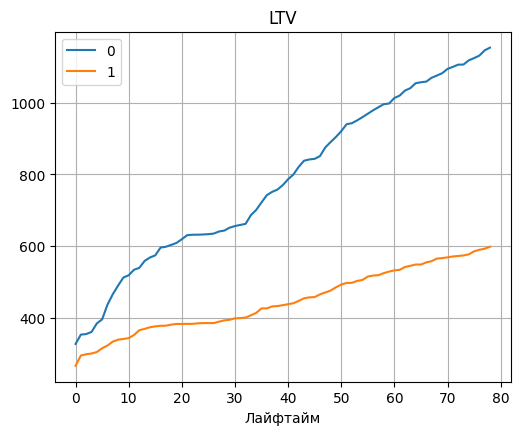

In [ ]:
observation_date = df['purchase_date'].max()
horizon_date = 79 # Макимальный срок, который получилось выбрать

ltv_raw, ltv, ltv_history = get_ltv(
    profiles, observation_date, horizon_date, dimensions=['loyalty_program']
)

plot_ltv_roi(ltv, ltv_history, horizon_date)

На всем сроке анализа видно, что LTV лучше у клиентов без системы лояльности

Вывод:

Построенный график LTV показал, что показатель лучше у пользователей без программы лояльности, причем намного больше, чем с программой лояльности

# Шаг 4. Проверка гипотезы

### Покупают ли больше покупатели, у которых есть система лояльности?

**Нулевая гипотиза**:  Средние продажи равны между пользователями с программой лояльности и без

**Альтернативная гипотеза**: Средние продажи **не**  равны между пользователями с программой лояльности и без

Для её проверки воспользуюсь методом `scipy.stats.ttest_ind (array1, array2, equal_var)`

Для определения `equal_var` сравню дисперсии:

In [ ]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

In [ ]:
loyal_money = df.query('cat_qua == "Покупки"')[['loyalty_program','value']].dropna()

var_ly = round(np.var(loyal_money.query('loyalty_program == 1')['value'], ddof=1),1)
var_ln = round(np.var(loyal_money.query('loyalty_program == 0')['value'], ddof=1),1)

print("Есть программа лояльности:",var_ly)
print("Нет программы лояльности:", var_ln)

Есть программа лояльности: 478.5
Нет программы лояльности: 509.8


In [ ]:
#Дисперсии отличаются, поэтому equal_var = False
results = st.ttest_ind (
    loyal_money.query('loyalty_program == 1')['value'].astype('int'),
    loyal_money.query('loyalty_program == 0')['value'].astype('int'),
    equal_var = False
)

print('p-значение:', results.pvalue )

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, средние не равны")
else:
    print("Не получилось отвергнуть нулевую гипотезу, средние равны")

p-значение: 0.06621953729387514
Не получилось отвергнуть нулевую гипотезу, средние равны


In [ ]:
#Дополнительная проверка
print('Данные тех у кого есть программа лояльности:',loyal_money.query('loyalty_program == 1')['value'].astype('int').mean().round(2))
print('Данные тех у кого нет программы лояльности :',loyal_money.query('loyalty_program == 0')['value'].astype('int').mean().round(2))

Данные тех у кого есть программа лояльности: 17.35
Данные тех у кого нет программы лояльности : 16.96


#### Вывод
~~Гипотеза проверена: Средние продажи **не** равны между пользователями с программой лояльности и без~~

Гипотеза проверена: Средние продажи равны между пользователями с программой лояльности и без
  

В целом данная проверка гипотезы показывает, что клиенты состоящие в программе лояльности не получают какой-то существенной выгоды, чтобы покупать больше

# Шаг 5. Вывод

Были представлены два блока данных. Первый с продажами, второй с ценами на товары.

По ним обоим была проведена по предобработке. Были изменены названия по змеиному регистру, изменены типы столбцов, поправлены пустые значения, обработы дубликаты. Сведены два датафрейма в один и получены денежные значения, путем перемножение проданных штук и цены на товар.

Мы имеем данные за три месяца. С декабря 2016 по февраль 2017 годов.

Были отрезаны аномальные значения. Аномальные значения с отрицательным количеством были проанализированы. Была выявлена закономерность, что есть некоторое количество клиентов, которые приходят в один или максимум два магазина для возврата. Тоже самое было выявлено и с аномальными положительными значениями. Самые прибыльные клиенты были показаны.

В блоке данных есть значения трех типов: отрицательные, нулевые и положительные значения. Отрицательные значения это возвраты их около 35% из всего блока данных. Нулевые значения не удалось определить что это, их около 2%. Остальные данные это реальные покупки, их около 65% из получившеегося dataframe. В дальнейших расчетах будут использоваться значения только по реальным покупкам.

У нас есть информация по 31 магазинам. Присутствуем супер магазин shop 0, который делает 87% продаж товаров и 86% продаж в деньгах. Некоторые магазины относительно новые. Если смотреть поменяно, то в декабре было 8 магазинов, а в январе и феврале по 11 штук. Причем есть shop 1 и shop 30. Они открылись в один день 28-02, во втором магазине за день продали 8582 товаров, а в первом 57. Если смотреть на покупки клиентов с программой лояльности и без по магазинам, то есть только 4 магазина, где есть покупки клиентов с программой лояльности (Shop 0, 8, 19 и 28). В трех продажи маленькие, но разбив покупок интересный. В 8 магазине доля покупок по программе лояльности около 3%, в 19 магазине почти 59%, а в 28 магазине покупают только по программе лояльности. В 0 магазине доля около 29%.

Помесячные суммарные продажи на графиках показали больше выручку людей без программы лояльности, чем с программой лояльности. Медианые значения уже менее стабильны, график скачет по тем у кого есть программа лояльности.
Клиенты предпочитают совершать покупки утром. Только у тех у кого нет программы лояльности приезжают раньше, тех у кого она есть.

Графики MAU/WAU/DAU показывают, что активных клиентов всегд выше, чем клиентов без программы лояльности.

Всего зарегистрированных пользователей 1580. 34% пользователей состоят программе лояльности. Если смотреть по топ10 самых активных в плане покупок пользователей, то только 1 из 10 состоит в программе лояльности. По медианому чеку только 2 из 10 состоят в программе лояльности.
В целом медианая покупка у тех кто состоит в программе лояльности выше почти на 20% в деньгах, а в штуках на 15% больше.

График LTV показал, что на дистанции клиенты без программы лояльности приносят больше денег, чем без программы лояльности.

Была выдвинута гипотеза, что средние продажи равны между клиентами с программой лояльности и без нее. Исследование показало, что отвергать её нельзя. Средние значения близки.  
В целом данная проверка гипотезы показывает, что клиенты состоящие в программе лояльности не получают какой-то существенной выгоды, чтобы покупать больше

Общий вывод по эффективности программы лояльности.

Программу лояльности необходимо пересмотреть, она не показывает свою эффективность. Она не дает существенной выгоды клиентам и они в целом совершают даже немного меньше(если опираться на медианый чек), чем пользовали без программы лояльности. Также они менее активны, как с точки зрения количества посещаемых магазинов (только в 4 магазинах из 31 есть продажи по программе лояльности). Можно изучить опыт магазина 28, там все продажи осуществляются клиентами по программе лояльности.



